# transfer learning

In [20]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping 
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json
import cv2

In [21]:
cifar10=keras.datasets.cifar10

In [22]:
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

In [23]:
print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 1)


In [24]:
x_train=np.array([cv2.resize(i,(64,64)) for i in x_train])
x_test=np.array([cv2.resize(i,(64,64)) for i in x_test])

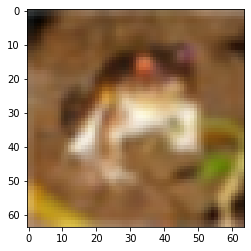

In [25]:
plt.imshow(x_train[0])

In [26]:
x_train=preprocess_input(x_train)
x_test=preprocess_input(x_test)
y_train=keras.utils.to_categorical(y_train,num_classes=10)
y_test=keras.utils.to_categorical(y_test,num_classes=10)

In [27]:
y_test[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [28]:
vgg=VGG16(input_shape=(64,64,3),weights='imagenet',include_top=False,classes=y_train.shape[1])

In [29]:
vgg.input

<KerasTensor: shape=(None, 64, 64, 3) dtype=float32 (created by layer 'input_2')>

In [30]:
for layer in vgg.layers:
    layer.trainable=False

In [31]:
# Add classification layers on top of it
x=keras.layers.Flatten()(vgg.output)
x=keras.layers.BatchNormalization()(x)
# x=keras.layers.Dense(2048,activation='relu')(x)
# x=keras.layers.BatchNormalization()(x)
# x=keras.layers.Dense(1024,activation='relu')(x)
# x=keras.layers.Dropout(0.5)(x)
# x=keras.layers.Dense(512,activation='relu')(x)
# x=keras.layers.Dropout(0.4)(x)
x=keras.layers.Dense(256,activation='relu')(x)
# x=keras.layers.Dropout(0.5)(x)
x=keras.layers.Dense(256,activation='relu')(x)
x=keras.layers.Dropout(0.6)(x)
output=keras.layers.Dense(10,activation='softmax')(x)
model_vgg=keras.models.Model(inputs=vgg.input,outputs=output)
model_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [42]:
# model_vgg.compile(
# optimizer='adam',
# loss=keras.losses.SparseCategoricalCrossentropy(),
# metrics=['accuracy'])
model_vgg.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy']
             )

In [43]:
# x_test[0]

In [44]:
callbacks=[EarlyStopping(monitor='val_accuracy',patience=5)]

In [45]:
# train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
# val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

In [46]:
history=model_vgg.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=5,batch_size=32,steps_per_epoch=x_train.shape[0] // 32,validation_steps=x_test.shape[0]//32,callbacks=callbacks)

Epoch 1/5
1562/1562 [==============================] - 1199s 766ms/step - loss: 0.9369 - accuracy: 0.6865 - val_loss: 0.6908 - val_accuracy: 0.7631
Epoch 2/5
1562/1562 [==============================] - 1181s 757ms/step - loss: 0.7220 - accuracy: 0.7561 - val_loss: 0.6891 - val_accuracy: 0.7672
Epoch 3/5
1562/1562 [==============================] - 1189s 761ms/step - loss: 0.6291 - accuracy: 0.7861 - val_loss: 0.6681 - val_accuracy: 0.7788
Epoch 4/5
1562/1562 [==============================] - 1189s 761ms/step - loss: 0.5639 - accuracy: 0.8073 - val_loss: 0.6565 - val_accuracy: 0.7835
Epoch 5/5
1562/1562 [==============================] - 1174s 752ms/step - loss: 0.4987 - accuracy: 0.8285 - val_loss: 0.6864 - val_accuracy: 0.7779


In [ ]:
for j in list(history.history.keys()):
    plt.plot(history.history[j])
    plt.title(j + ' over epochs')
    plt.ylabel(j)
    plt.xlabel('Epochs')
    plt.show()

In [ ]:
model_json = model.to_json()
with open("model_cifar_trans.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_cifar_trans.h5")
print("Saved model to disk")